In [2]:
from pathlib import Path
from dataclasses import dataclass

import datasets
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

## 1. load and inspect the dataset

In [3]:
data_path = Path('./pp16_8k/data')

train_files = list(data_path.glob('train*'))
train_files = sorted([train_file.name for train_file in train_files])
validation_files = list(data_path.glob('validation*'))
validation_files = sorted([validation_file.name for validation_file in validation_files])

In [4]:
labels2names = {
    0: 'complex',
    1: 'frog_eye_leaf_spot',
    2: 'healthy',
    3: 'powdery_mildew',
    4: 'rust',
    5: 'scab'
}

names2labels = {v: k for k, v in labels2names.items()}

In [5]:
# the plant-pathology-2021 dataset
ds = datasets.load_dataset(
    './pp16_8k/data',
    data_files={
        'train': train_files,
        'validation': validation_files
    }
)

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/26 [00:00<?, ?it/s]

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'label_names', 'image_id'],
        num_rows: 16210
    })
    validation: Dataset({
        features: ['image', 'labels', 'label_names', 'image_id'],
        num_rows: 1864
    })
})

In [6]:
train_ds = ds['train']
validation_ds = ds['validation']

In [7]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4000x2672>,
 'labels': [2],
 'label_names': ['healthy'],
 'image_id': '84a507f705587f78'}

In [8]:
validation_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4000x2672>,
 'labels': [5],
 'label_names': ['scab'],
 'image_id': 'dae1c1a28f9e3cc8'}

### 1.1 statistical summary of the training dataset

In [9]:
label_names_all = [name 
                   for names in train_ds['label_names']
                   for name in names]

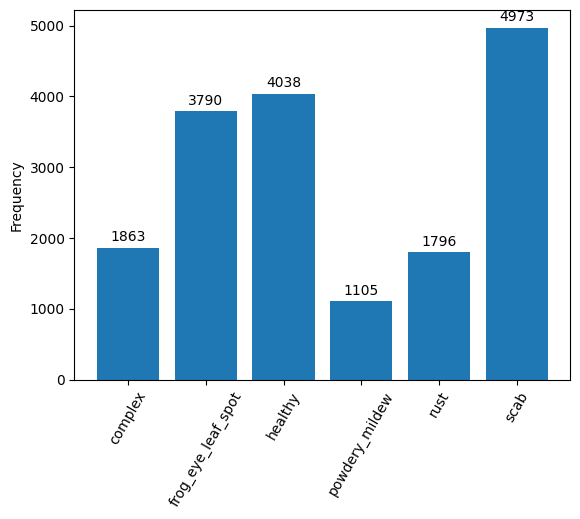

In [10]:
from collections import Counter
label_counts = Counter(label_names_all)
bars = plt.bar(sorted(label_counts.keys()),
               [label_counts[key] for key in sorted(label_counts.keys())])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom')
_ = plt.xticks(rotation=60)
_ = plt.ylabel('Frequency')

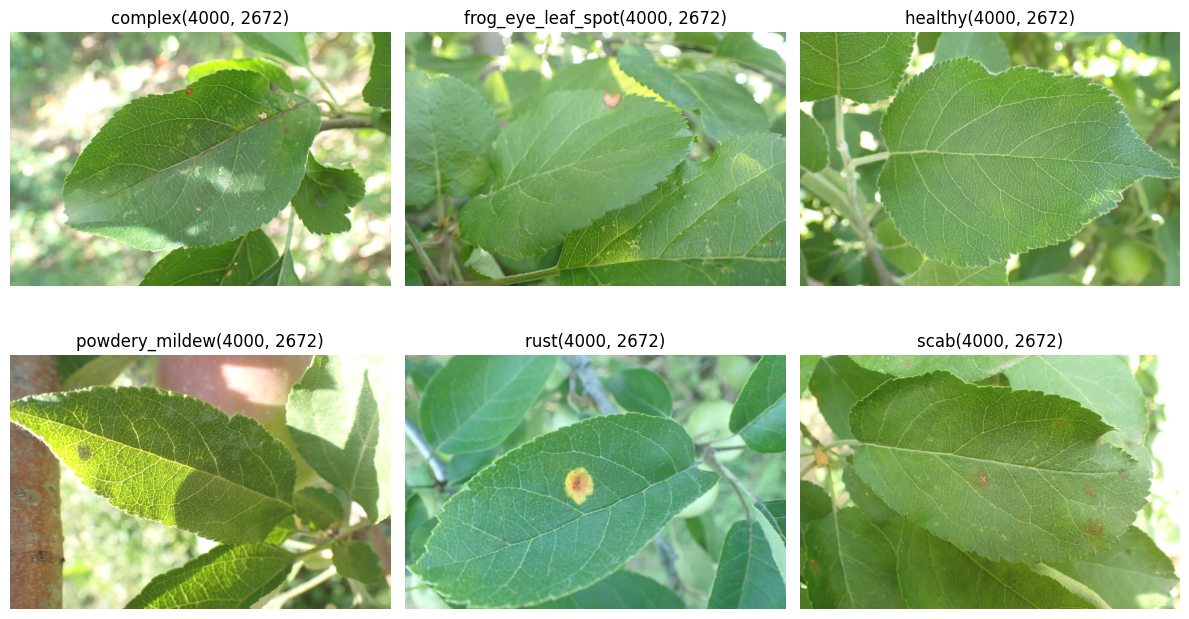

In [11]:
idx4plot = []

fig, axs = plt.subplots(2, 3, layout='tight', figsize=(12, 8))
for ax, label in zip(axs.flat, labels2names.keys()):
    img_index = next(i
                     for i, labels in enumerate(train_ds['labels'])
                     if label in labels and i not in idx4plot)
    idx4plot.append(img_index)
    img = train_ds[img_index]['image']
    ax.imshow(img)
    ax.set_title(f'{labels2names[label]}{img.size}')
    ax.axis('off')

# some images have more than one label

In [12]:
idx4plot

[4, 8, 0, 14, 11, 2]

## 2. Tranform images and build dataloader

### 2.1 transform without normalize

In [37]:
trans_rules = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize()
])

def transform_image(samples):
    samples['pixel_values'] = [trans_rules(img) for img in samples['image']]
    return samples

train_ds = train_ds.with_transform(transform_image)

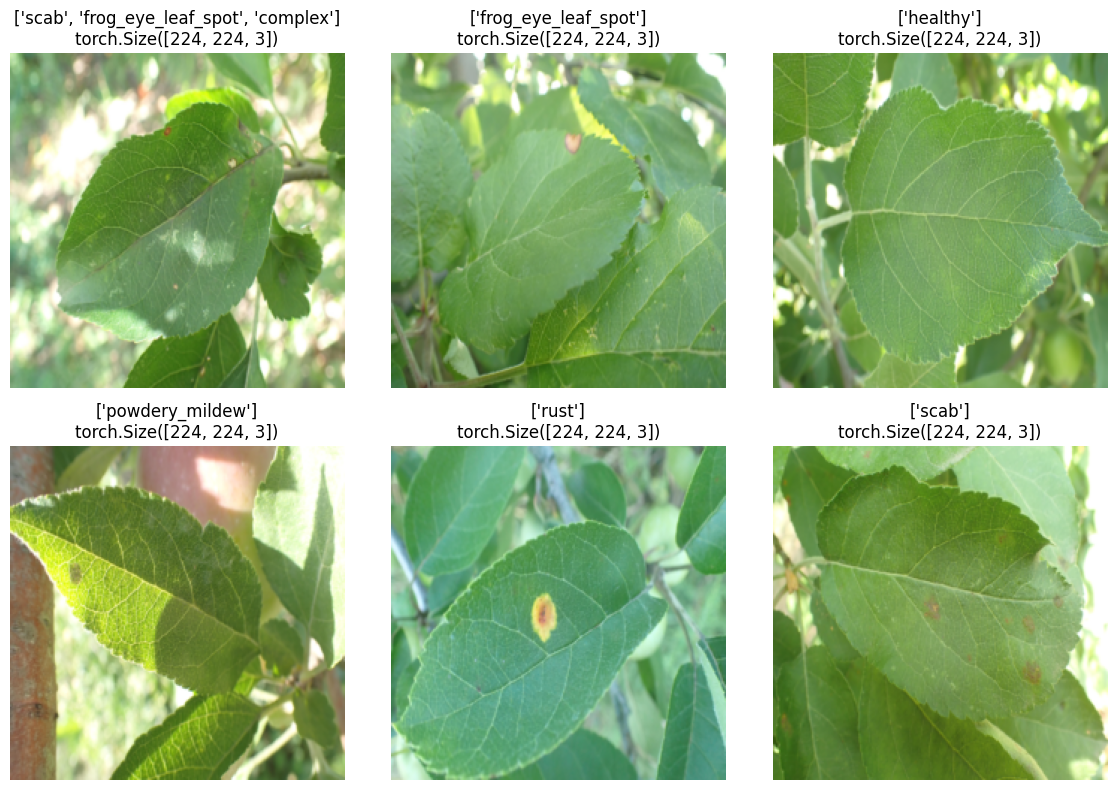

In [39]:
fig, axs = plt.subplots(2, 3, layout='tight', figsize=(12, 8))
for ax, idx in zip(axs.flat, idx4plot):
    inp = train_ds[idx]['pixel_values'].permute(1, 2, 0)
    ax.imshow(inp)
    ax.set_title(f"{train_ds[idx]['label_names']}\n{inp.shape}") # size: (3, 256, 256)
    ax.axis('off')

### 2.2 Caculate the mean and std of the dataset

In [40]:
def collate_fn(samples):
    images = [sample['pixel_values'] for sample in samples]
    pixel_values = torch.stack(images)
    return {'pixel_values': pixel_values}

dataloader = DataLoader(train_ds, batch_size=4, collate_fn=collate_fn)

In [42]:
def calculate_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    total_images = 0

    for images in dataloader:
        images = images['pixel_values']
        # images is of shape (batch_size, 3, H, W)
        batch_samples = images.size(0)  # Number of images in the batch
        # Flatten H and W dimensions
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)  # Compute mean for each channel
        std += images.std(2).sum(0)    # Compute std for each channel
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(dataloader)
print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.4870, 0.6265, 0.4082])
Std: tensor([0.1668, 0.1456, 0.1742])


### 2.3 encode the labels
We use multi-hot encoding here

In [ ]:
trans_rule = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4870, 0.6265, 0.4082],
                         std=[0.1668, 0.1456, 0.1742])])

def trans(batch):
    return {
        'pixel_values': [trans_rule(img) for img in batch['image']],
        'encoded_labels': torch.tensor([[1 if i in labels else 0    # multi-hot encoding
                                            for i in range(6)]
                                            for labels in batch['labels']],
                                            dtype=torch.float32)
    }

## 3. Construct the model

In [7]:
# according to https://pytorch.org/docs/stable/generated/torch.nn.modules.normalization.RMSNorm.html
# if you have torch version >= 2.4.0, you can use nn.RMSNorm() defined in the library
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        # reciprocal
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

In [8]:
class FFNSwishGLU(nn.Module):
    def __init__(self, embed_dim, hidden_dim, bias=False, dropout=0.0):
        super().__init__()
        self.ln1 = nn.Linear(embed_dim, hidden_dim, bias=bias)
        self.ln2 = nn.Linear(hidden_dim, embed_dim, bias=bias)
        self.ln3 = nn.Linear(embed_dim, hidden_dim, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(
            self.ln2(
                F.silu(self.ln1(x)) * self.ln3(x)
            )
        )
    
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, bias=False, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.dropout = dropout
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim, bias=bias)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def forward(self, x):
        # x is [batch_size, seq_len, embed_dim]
        batch_size, seq_len, embed_dim = x.size()
        q, k, v = self.qkv(x).split(self.embed_dim, dim=-1)
        # [batch_size, seq_len, embed_dim] -> [batch_size, num_heads, seq_len, ,head_dim]
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        y = F.scaled_dot_product_attention(q, k, v, dropout_p=self.dropout)
        y = y.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)

        return self.proj(y)

class Block(nn.Module):
    def __init__(self, embed_dim, num_heads, bias=False, dropout=0.0):
        super().__init__()
        self.norm1 = RMSNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, bias, dropout)
        self.norm2 = RMSNorm(embed_dim)
        self.ffn = FFNSwishGLU(embed_dim, embed_dim*4, bias, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

# ---------------------------
@dataclass
class PPClassifierConfig:
    image_size: int = 224
    patch_size: int = 16
    num_classes: int = 6

    embed_dim: int = 768
    num_heads: int = 12
    num_layers: int = 6
    bias: bool = False
    dropout: float = 0.0
# ----------------------------

class PPClassifier(nn.Module):
    def __init__(self, config: PPClassifierConfig):
        super().__init__()
        self.config = config

        self.num_patches = (config.image_size // config.patch_size) ** 2 # default=196

        # more efficient to use a conv layer than flatten & linear
        self.patch_embedding = nn.Conv2d(3, config.embed_dim,
                                         kernel_size=config.patch_size,
                                         stride=config.patch_size)
        #learnable class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.embed_dim))
        
        # learnable positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, config.embed_dim) * 0.02)

        self.blocks = nn.ModuleList([
            Block(config.embed_dim, config.num_heads, config.bias, config.dropout)
            for _ in range(config.num_layers)
        ])

        self.norm = RMSNorm(config.embed_dim)
        self.head = nn.Linear(config.embed_dim, config.num_classes, bias=config.bias)

    def forward(self, x):
        batch_size = x.size(0)
        # x is [batch_size, 3, image_size, image_size]
        # patch embedding -> [batch_size, embed_dim, num_patches, num_patches]
        x = self.patch_embedding(x)
        x = x.flatten(2, -1).transpose(1, 2)
        # cls token [1, 1, embed_dim] -> [batch_size, 1, embed_dim]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding

        for block in self.blocks:
            x = block(x)

        # x is [batch_size, num_patches+1, embed_dim]
        x = self.norm(x[:, 0])
        x = self.head(x)
        return x

### 3.1 Number of model parameters

In [65]:
config = PPClassifierConfig()
model = PPClassifier(config)

# number of parameters
sum(p.numel() for p in model.parameters()) # 57,380,352 ~= 57M
model = model.to('cuda') # ~= 400 MB

In [53]:
torch.cuda.is_bf16_supported()

False

## 4. Training it

The model was training on 2 RTX 2080TI (11 Gb). And the total batch size is of 128 (64 per GPU). Following is the command, for training details, refer to the `train.py`:
```bash
torchrun --standalone --nproc_per_node 2 train.py
```

### 4.1 represent the training results

In [3]:
import math
def get_lr(step, warmup_steps, lr_decay_steps, max_lr, min_lr):
    # 1) linear warmup for warmup steps
    if step < warmup_steps:
        return max_lr * (step + 1) / (warmup_steps + 1)
    # 2) constant learning rate for lr_decay_steps
    if step > lr_decay_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (step - warmup_steps) / (lr_decay_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (max_lr - min_lr)

def get_step_loss(log_file):
    train_steps = []
    train_losses = []
    validation_steps = []
    validation_losses = []
    norms = []
    with open(log_file, 'r') as f:
        for line in f:
            line_list = line.strip().split()
            if len(line_list) == 11:
                train_steps.append(int(line_list[2][:-1]))
                train_losses.append(float(line_list[4]))
                norms.append(float(line_list[7]))
            elif len(line_list) == 5:
                validation_steps.append(int(line_list[2][:-1]))
                validation_losses.append(float(line_list[4]))
    return train_steps, train_losses, validation_steps, validation_losses, norms

#### 4.1.1 Training results for the first time

- log_interval = 10
- eval_interval = 50

- max_lr = 0.03
- min_lr = 0.003
- max_steps = 1200
- warmup_steps = 100

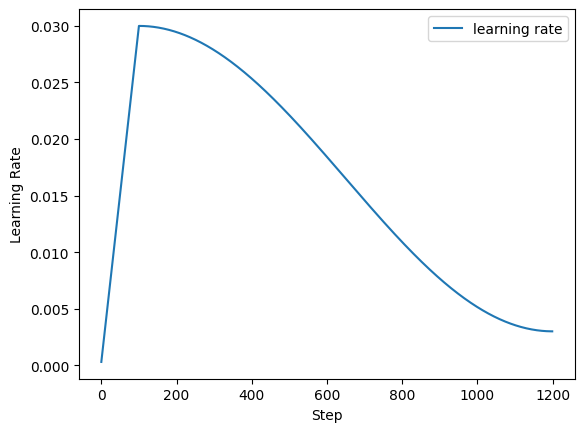

In [4]:
# plot the learning rate schedule
warmup_steps = 100
lr_decay_steps = 1200
max_lr = 0.03
min_lr = 0.003
steps = list(range(lr_decay_steps))
lrs = [get_lr(step, warmup_steps, lr_decay_steps, max_lr, min_lr) for step in steps]
plt.plot(steps, lrs, label='learning rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()

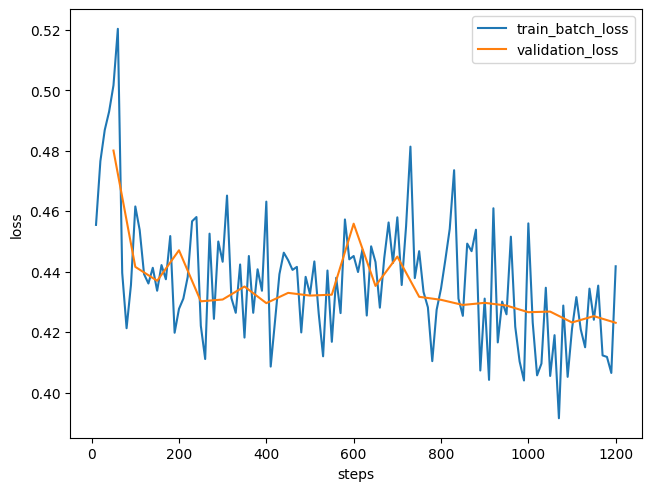

In [3]:
log_file = 'log/log.txt'
train_steps, train_losses, validation_steps, validation_losses, norms = get_step_loss(log_file)

fig, ax = plt.subplots(layout='constrained')
ax.plot(train_steps, train_losses, label='train_batch_loss')
ax.plot(validation_steps, validation_losses, label='validation_loss')
ax.set_xlabel('steps')
ax.set_ylabel('loss')
ax.legend()

#### 4.1.2 The training results of the second time

- log_interval = 20
- eval_interval = 100
- max_lr = 0.01
- min_lr = 0.001
- max_steps = 6000
- warmup_steps = 200

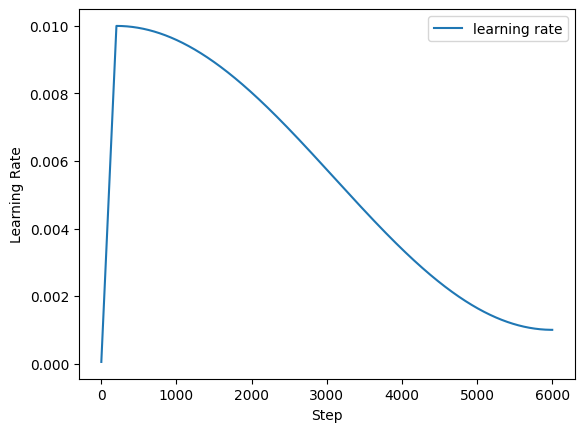

In [5]:
# plot the learning rate schedule
warmup_steps = 200
lr_decay_steps = 6000
max_lr = 0.01
min_lr = 0.001
steps = list(range(lr_decay_steps))
lrs = [get_lr(step, warmup_steps, lr_decay_steps, max_lr, min_lr) for step in steps]
plt.plot(steps, lrs, label='learning rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()

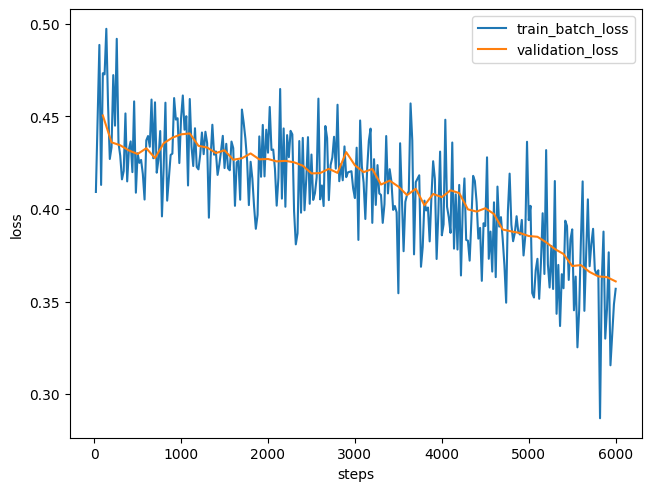

In [6]:
log_file = 'log/log.txt'
train_steps, train_losses, validation_steps, validation_losses, norms = get_step_loss(log_file)

fig, ax = plt.subplots(layout='constrained')
ax.plot(train_steps, train_losses, label='train_batch_loss')
ax.plot(validation_steps, validation_losses, label='validation_loss')
ax.set_xlabel('steps')
ax.set_ylabel('loss')
ax.legend()

### 4.2 Inspect the behavior of the model on validation dataset

In [9]:
def preprocess(img):
    trans_rule = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4870, 0.6265, 0.4082],
                             std=[0.1668, 0.1456, 0.1742])
    ])
    img = trans_rule(img)
    return img

In [10]:
# load model
weight_path = 'output/final_model_state_dict.pth'
config = PPClassifierConfig()
model = PPClassifier(config)
model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [11]:
model = model.to('cuda')

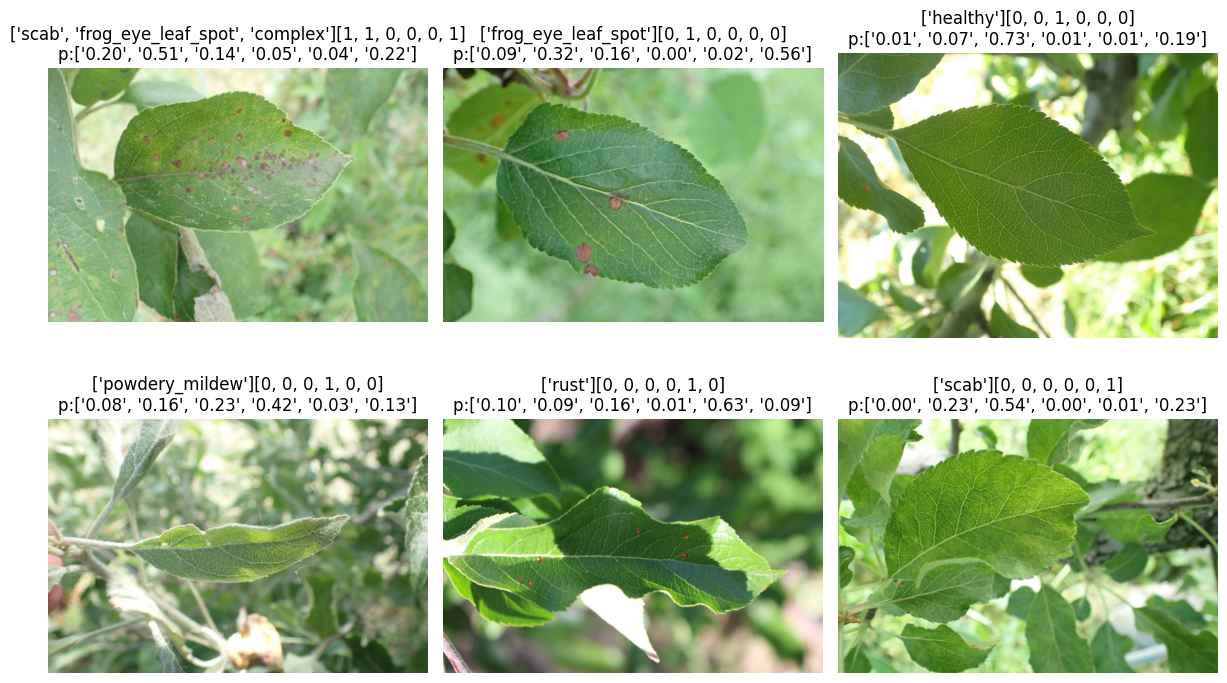

In [12]:
idx4plot = [2, 4, 8, 21, 1, 0]

fig, axs = plt.subplots(2, 3, layout='tight', figsize=(12, 8))
for ax, label in zip(axs.flat, labels2names.keys()):
    img_index = next(i
                     for i, labels in enumerate(validation_ds['labels'])
                     if label in labels and i not in idx4plot)
    idx4plot.append(img_index)
    data = validation_ds[img_index]
    img = data['image']
    ax.imshow(img)
    img = preprocess(img)
    img = img.unsqueeze(0)  
    with torch.no_grad():
        model.eval()
        img = img.to('cuda')
        output = model(img)
        pred = torch.sigmoid(output).cpu().numpy().flatten()
    pred = [f'{p:.2f}' for p in pred]
    ax.set_title(f"{data['label_names']}{[1 if i in data['labels'] else 0 for i in range(6)]}\np:{pred}")
    ax.axis('off')

### 4.3 Bonus part: inference GUI

See the `inference.py` for details

In [81]:
weight_path = 'output/final_model_state_dict.pth'

config = PPClassifierConfig()
model = PPClassifier(config)
model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [82]:
# Build app
def inference(img, device='auto'):
    global model
    if device == 'auto':
        if torch.cuda.is_available():
            device = 'cuda'
        elif torch.backends.mps.is_available():
            device = 'mps'
        else:
            device = 'cpu'
    model = model.to(device)
    model.eval()
    img = preprocess(img)
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(img)
    probs = torch.sigmoid(logits).cpu().numpy().flatten()
    confidences = {labels2names[i]: probs[i] for i in range(6)}
    return confidences